In [1]:
!pip install tf-nightly

In [ ]:
import tensorflow as tf
tf.__version__

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

In [2]:
# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

In [3]:
# import training data and combine labels
data_x, data_y  = load_data() 

## Augmentation

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-90,90)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        ,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        ,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        ,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


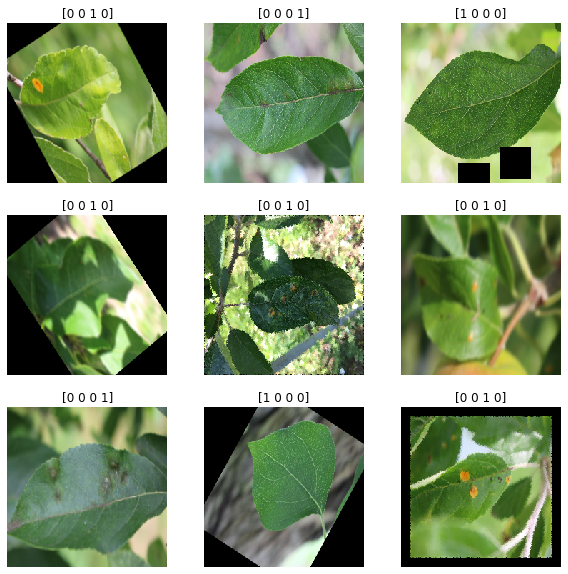

In [6]:
images = generator(data_x,data_y, 9)
image = next(images)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    #augmented_image = seq(images = x_train[:1])
    plt.imshow(image[0][i])
    plt.title(str(image[1][i]))
    plt.axis("off")

## Transfer Learning

In [7]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.30, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

test_x, test_id  = load_data("Test") 

In [9]:
base_model = applications.EfficientNetB0(
    weights='imagenet',
    input_shape=(image_size, image_size, 3),
    include_top=False)

In [10]:
# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(4)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [11]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
model.layers[1].trainable = False

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model.optimizer.lr)


# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

# freeze pretrained weights
model.layers[1].trainable = True

model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/100
19/19 [==============================] - 31s 1s/step - loss: 6.1814 - sparse_categorical_crossentropy: 6.1814 - val_loss: 3.8824 - val_sparse_categorical_crossentropy: 3.8824
Epoch 2/100
19/19 [==============================] - 25s 1s/step - loss: 4.2075 - sparse_categorical_crossentropy: 4.2075 - val_loss: 3.6718 - val_sparse_categorical_crossentropy: 3.6718
Epoch 3/100
19/19 [==============================] - 25s 1s/step - loss: 3.8841 - sparse_categorical_crossentropy: 3.8841 - val_loss: 2.7547 - val_sparse_categorical_crossentropy: 2.7547
Epoch 4/100
19/19 [==============================] - 25s 1s/step - loss: 3.1358 - sparse_categorical_crossentropy: 3.1358 - val_loss: 2.3856 - val_sparse_categorical_crossentropy: 2.3856
Epoch 5/100
19/19 [==============================] - 25s 1s/step - loss: 2.7552 - sparse_categorical_crossentropy: 2.7552 - val_loss: 1.9379 - val_sparse_categorical_crossentropy: 1.9379
Epoch 6/100
19/19 [==============================] - 25s 1s/step 

In [40]:
model = keras.models.load_model('models/efficientNet_9368')

In [42]:
maxIter = 3
iter = 0

# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)


model.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

while iter < maxIter:
    test_y = model.predict(test_x)
    test_pred = tf.nn.softmax(test_y).numpy()
    pred_label = np.argmax(test_pred, axis=1)
    
    merged_data_x = np.vstack((x_train, test_x))
    merged_data_y = np.vstack((y_train.reshape(-1,1), pred_label.reshape(-1,1)))

    history2 = model.fit(generator(merged_data_x, merged_data_y, batch_size),  
                        shuffle=True,  
                        validation_data = (x_val, y_val),
                        callbacks = [reduce_lr,early_stop],                        
                        epochs=200,
                        steps_per_epoch=len(merged_data_x)/batch_size ,
                        verbose=True
                       )
    
    
    #try kaggle
    test_pred = tf.nn.softmax(test_y).numpy()
    test_set = np.hstack((test_id, test_pred))
    test_set = test_set[test_set[:,1].astype('uint16').argsort()]
    test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
    csv_file = f'submissions/efficientNet{iter}.csv'
    test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv(csv_file, index=False)
    comments = f'"efficientNet iter {iter} 20210206"'
    !kaggle competitions submit -f $csv_file -m$comments plant-pathology-2020-fgvc7
    !kaggle competitions submissions plant-pathology-2020-fgvc7
    model.save(f'models/efficientNet_{iter}')
    
    iter += 1

Epoch 1/200
48/48 [==============================] - 180s 4s/step - loss: 0.2033 - accuracy: 0.2526 - val_loss: 0.1624 - val_accuracy: 0.3016
Epoch 2/200
48/48 [==============================] - 172s 4s/step - loss: 0.1249 - accuracy: 0.2432 - val_loss: 0.1900 - val_accuracy: 0.2943
Epoch 3/200
48/48 [==============================] - 173s 4s/step - loss: 0.1072 - accuracy: 0.2725 - val_loss: 0.1875 - val_accuracy: 0.2925
Epoch 4/200
48/48 [==============================] - 174s 4s/step - loss: 0.0910 - accuracy: 0.2647 - val_loss: 0.2461 - val_accuracy: 0.3126
Epoch 5/200
48/48 [==============================] - 173s 4s/step - loss: 0.1064 - accuracy: 0.2395 - val_loss: 0.1961 - val_accuracy: 0.3053
Epoch 6/200
48/48 [==============================] - 173s 4s/step - loss: 0.0690 - accuracy: 0.2601 - val_loss: 0.2405 - val_accuracy: 0.3090
Epoch 7/200
48/48 [==============================] - 171s 4s/step - loss: 0.0876 - accuracy: 0.2641 - val_loss: 0.2108 - val_accuracy: 0.2998
Epoch 

INFO:tensorflow:Assets written to: models/efficientNet_0/assets


Epoch 1/200
48/48 [==============================] - 172s 4s/step - loss: 0.0660 - accuracy: 0.2449 - val_loss: 0.2125 - val_accuracy: 0.2980
Epoch 2/200
48/48 [==============================] - 173s 4s/step - loss: 0.0832 - accuracy: 0.2452 - val_loss: 0.2147 - val_accuracy: 0.3071
Epoch 3/200
48/48 [==============================] - 173s 4s/step - loss: 0.0615 - accuracy: 0.2545 - val_loss: 0.1960 - val_accuracy: 0.2998
Epoch 4/200
48/48 [==============================] - 172s 4s/step - loss: 0.0724 - accuracy: 0.2516 - val_loss: 0.2036 - val_accuracy: 0.3090
Epoch 5/200
48/48 [==============================] - 173s 4s/step - loss: 0.0675 - accuracy: 0.2506 - val_loss: 0.2132 - val_accuracy: 0.3108
Epoch 6/200
48/48 [==============================] - 173s 4s/step - loss: 0.0619 - accuracy: 0.2554 - val_loss: 0.2088 - val_accuracy: 0.3090
Epoch 7/200
48/48 [==============================] - 172s 4s/step - loss: 0.0645 - accuracy: 0.2420 - val_loss: 0.2005 - val_accuracy: 0.3053
Epoch 

INFO:tensorflow:Assets written to: models/efficientNet_1/assets


Epoch 1/200
48/48 [==============================] - 173s 4s/step - loss: 0.0503 - accuracy: 0.2490 - val_loss: 0.2315 - val_accuracy: 0.3126
Epoch 2/200
48/48 [==============================] - 171s 4s/step - loss: 0.0562 - accuracy: 0.2592 - val_loss: 0.2292 - val_accuracy: 0.3108
Epoch 3/200
48/48 [==============================] - 172s 4s/step - loss: 0.0436 - accuracy: 0.2503 - val_loss: 0.2358 - val_accuracy: 0.3108
Epoch 4/200
48/48 [==============================] - 172s 4s/step - loss: 0.0432 - accuracy: 0.2500 - val_loss: 0.2402 - val_accuracy: 0.3108
Epoch 5/200
48/48 [==============================] - 171s 4s/step - loss: 0.0561 - accuracy: 0.2411 - val_loss: 0.2517 - val_accuracy: 0.3144
Epoch 6/200
48/48 [==============================] - 172s 4s/step - loss: 0.0491 - accuracy: 0.2500 - val_loss: 0.2517 - val_accuracy: 0.3144
Epoch 7/200
48/48 [==============================] - 171s 4s/step - loss: 0.0472 - accuracy: 0.2481 - val_loss: 0.2191 - val_accuracy: 0.3090
Epoch 

INFO:tensorflow:Assets written to: models/efficientNet_2/assets


In [15]:
model.save('models/efficientNet_9368')

INFO:tensorflow:Assets written to: models/efficientNet_9368/assets


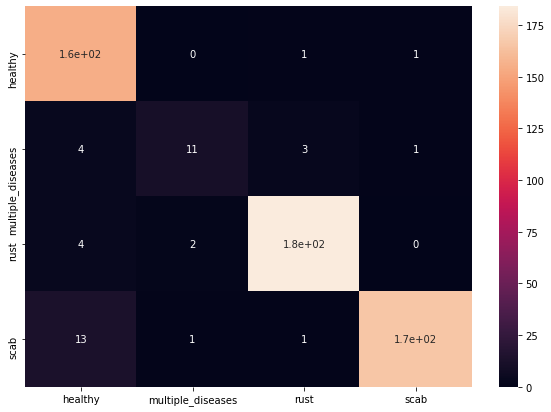

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [22]:
# Train on all data before inference
model.fit(generator(x_val, y_val, batch_size),            
                    epochs=2,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/2
22/22 [==============================] - 569s 25s/step - loss: 0.1355 - accuracy: 0.9667
Epoch 2/2
22/22 [==============================] - 568s 25s/step - loss: 0.0629 - accuracy: 0.9823


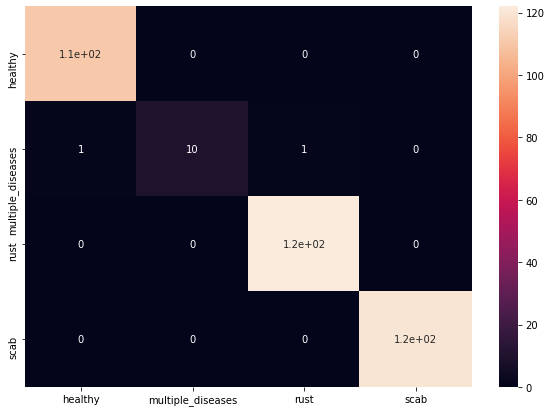

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [37]:
# Load test data and their filename for submission file
#test_x, test_id  = load_data("Test") 
test_y = model.predict(test_x)
test_pred = tf.nn.softmax(test_y).numpy()
test_set = np.hstack((test_id, test_pred))
test_set = test_set[test_set[:,1].astype('uint16').argsort()]
test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv('submissions/efficientNet.csv', index=False)

In [38]:
!kaggle competitions submit -f 'submissions/efficientNet.csv' -m"efficientNet baseline 20210130" plant-pathology-2020-fgvc7

100%|█████████████████████████████████████████| 106k/106k [00:00<00:00, 185kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

In [39]:
!kaggle competitions submissions plant-pathology-2020-fgvc7

fileName               date                 description                         status    publicScore  privateScore  
---------------------  -------------------  ----------------------------------  --------  -----------  ------------  
efficientNet.csv       2021-02-07 05:12:58  efficientNet baseline 20210130      complete  0.93478      0.93531       
efficientNet.csv       2021-02-07 03:07:58  efficientNet baseline 20210130      complete  0.94182      0.93685       
EfficientNetB6.csv     2021-02-06 20:03:18  EfficientNetB6 baseline 2021-02-06  complete  0.94181      0.92909       
EfficientNetB5.csv     2021-02-06 15:51:55  EfficientNetB5 baseline 2021-02-06  complete  0.94710      0.93022       
EfficientNetB4.csv     2021-02-06 13:32:05  EfficientNetB4 baseline 2021-02-06  complete  0.93628      0.93089       
EfficientNetB3.csv     2021-02-06 11:32:30  EfficientNetB3 baseline 2021-02-06  complete  0.93135      0.91675       
EfficientNetB2.csv     2021-02-06 10:28:00  EfficientNet

#### 0.9338 is #801 on leaderboard

## Convert to TFLite

In [27]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/xception") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/xception.tflite', 'wb') as f:
    f.write(tflite_model)

In [28]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/xception.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (image_size,image_size)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result118====
[[-5.5913553   0.10580774 -4.789981   10.428146  ]]
3
====TFLite result====
[[-6.151669   0.3389328 -5.203408  11.086818 ]]
3
====TF Model result529====
[[-1.854001  -1.206874   5.5994477 -3.6847982]]
2
====TFLite result====
[[-4.0978193 -1.6762551  9.454673  -6.213326 ]]
2
====TF Model result860====
[[-2.7240992 -1.0839779  5.8567367 -2.9417467]]
2
====TFLite result====
[[-5.7429442 -2.8852344 11.931892  -5.623218 ]]
2
====TF Model result691====
[[-2.3256586   0.12409084  3.7397826  -1.7892648 ]]
2
====TFLite result====
[[-5.9245753 -1.6625859 10.673811  -4.3376884]]
2
====TF Model result1246====
[[ 5.682509  -2.1599436 -2.9038138 -3.121694 ]]
0
====TFLite result====
[[ 5.380403  -2.773593  -2.660941  -4.1204834]]
0
